In [1]:
import os
import re

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from ndspflow.workflows import BIDS, WorkFlow
from timescales.fit import PSD

from mne.io import read_raw_edf
from mne_bids import BIDSPath, read_raw_bids

import nilearn
from nilearn import plotting, image 

from sklearn.preprocessing import minmax_scale

from timescales.fit import PSD
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

## Load MNE Data

In [2]:
# Determine indices of frontal regions
rpath = '/Users/ryanhammonds/projects/data/sleep2/Information/RegionInformation.csv'
regions = pd.read_csv(rpath)

# Load channel info
cpath = '/Users/ryanhammonds/projects/data/sleep2/Information/ChannelInformation.csv'
ch_info = pd.read_csv(cpath)

# Remove single quotes from channel names
ch_info['Channel name'] = [i[1:-1] for i in ch_info['Channel name']]

# Get row inds and channel names
rinds = [(i, j) for i, j in ch_info['Region'].items()]
inds = [i[0] for i in rinds]
rinds = [i[1] for i in rinds]

select = [i[1:-1] for i in ch_info.iloc[inds]['Channel name']]
select.sort()

# List of file names
files = os.listdir('/Users/ryanhammonds/projects/data/sleep2/data2')
files_noext  = [i[:-5] for i in files]

# Sort
inds = np.argsort(files_noext)
files_noext = np.array(files_noext)[inds]
files = np.array(files)[inds]

# Filter for Dixi intracerebral electrodes (largest sample size)
files_filt = []
regions_inds = []

for i, f in enumerate(files_noext):
    
    if f[1] == 'D':
        ind = (ch_info['Channel name'] == f).values
        regions_inds.append(ch_info[ind]['Region'].values[0])
        files_filt.append(files[i])
        
regions_inds = np.array(regions_inds)

In [3]:
# Convert list of file strings to one concat string
file_str = ''
for f in files:
    file_str += f
    
ch_files = {
    'wake':{'files':[], 'coords':[]},
    'nrem2':{'files':[], 'coords':[]},
    'nrem3':{'files':[], 'coords':[]},
    'rem':{'files':[], 'coords':[]}
}

trial_lookup = {'W': 'wake', 'N': 'nrem2', 'D': 'nrem3', 'R': 'rem'}

regions = []

inds = []

for i, ch in enumerate(ch_info['Channel name'].values):
    m = re.search(ch + '.\.edf', file_str)
    
    if m is not None:
        
        
        fstr = m.group()
        trial = fstr[-5]
        
        if trial == 'R':
            # skip rem sleep
            continue
            
        key = trial_lookup[trial]
            
        ch_files[key]['files'].append(fstr)

        ch_files[key]['coords'].append(
            (ch_info.iloc[i].x, ch_info.iloc[i].y, ch_info.iloc[i].z)
        )
        
        regions.append(ch_info.iloc[i].Region)
        
        inds.append(i)

## Fit Timescales

In [4]:
base_path = '/Users/ryanhammonds/projects/data/sleep2/data2/'

fs = 200

wake_files = ch_files['wake']['files']
nrem_files = [*ch_files['nrem2']['files'], *ch_files['nrem3']['files']]

n_wake_files = len(wake_files)
n_nrem_files = len(nrem_files)

wake_taus = np.zeros(n_wake_files)
wake_rsq = np.zeros(n_wake_files)

nrem_taus = np.zeros(n_nrem_files)
nrem_rsq = np.zeros(n_nrem_files)

for i, f in tqdm(enumerate(wake_files), total=len(wake_files)):
    
    edf = read_raw_edf(base_path + f, verbose=False)
    
    sig = edf.get_data()[0]
    sig = normalize_sig(sig, 0, 1)
    
    psd = PSD()
    psd.compute_spectrum(sig, fs, ar_order=5, f_range=(.01, 20))
    psd.fit()
    
    wake_taus[i] = psd.tau
    wake_rsq[i] = psd.rsq
    
    
for i, f in tqdm(enumerate(nrem_files), total=len(nrem_files)):
    
    edf = read_raw_edf(base_path + f, verbose=False)
    
    sig = edf.get_data()[0]
    sig = normalize_sig(sig, 0, 1)
    
    psd = PSD()
    psd.compute_spectrum(sig, fs, ar_order=5, f_range=(.01, 20))
    psd.fit()
    
    nrem_taus[i] = psd.tau
    nrem_rsq[i] = psd.rsq

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

In [5]:
# Organize results
inds = np.where(wake_rsq > .5)[0]
wake_taus = wake_taus[inds]
wake_rsq = wake_rsq[inds]
wake_coords = np.array(ch_files['wake']['coords'])[inds]
wake_taus_ms = wake_taus * 1000

inds = np.where(nrem_rsq > .5)[0]
nrem_taus = nrem_taus[inds]
nrem_rsq = nrem_rsq[inds]
nrem_coords = np.array([*ch_files['nrem2']['coords'], *ch_files['nrem3']['coords']])[inds]
nrem_taus_ms = nrem_taus * 1000

## Convert Timescales to Surface Map

In [6]:
template_path = '/Users/ryanhammonds/projects/data/sleep2/mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii'
template = image.load_img(template_path)

# Wake taus
wake_statmap = np.zeros_like(np.asanyarray(template.dataobj))
for c, t in zip(wake_coords, wake_taus_ms):
    i, j, k = image.coord_transform(*c, np.linalg.inv(template.affine))
    wake_statmap[int(i), int(j), int(k)] = t
wake_max_stat = wake_statmap.max()

# NREM taus
nrem_statmap = np.zeros_like(np.asanyarray(template.dataobj))
for c, t in zip(nrem_coords, nrem_taus_ms):
    i, j, k = image.coord_transform(*c, np.linalg.inv(template.affine))
    nrem_statmap[int(i), int(j), int(k)] = t
nrem_max_stat = nrem_statmap.max()

# Convert stat maps to smoothed nilearn images
radius = 20

wake_statmap = nilearn.image.new_img_like(template, wake_statmap)
wake_statmap_smooth = image.smooth_img(wake_statmap, radius)

nrem_statmap = nilearn.image.new_img_like(template, nrem_statmap)
nrem_statmap_smooth = image.smooth_img(nrem_statmap, radius)

In [7]:
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Volume to surface: wake
curv_right = nilearn.surface.load_surf_data(fsaverage.curv_right)
curv_right_sign = np.sign(curv_right)
texture_right = nilearn.surface.vol_to_surf(wake_statmap_smooth, fsaverage.pial_right, radius=radius)

curv_left = nilearn.surface.load_surf_data(fsaverage.curv_left)
curv_left_sign = np.sign(curv_left)
texture_left = nilearn.surface.vol_to_surf(wake_statmap_smooth, fsaverage.pial_left, radius=radius)

wake_texture_right = minmax_scale(texture_right, (0, wake_max_stat))
wake_texture_left = minmax_scale(texture_left, (0, wake_max_stat))

# Volume to surface: nrem
curv_right = nilearn.surface.load_surf_data(fsaverage.curv_right)
curv_right_sign = np.sign(curv_right)
texture_right = nilearn.surface.vol_to_surf(nrem_statmap_smooth, fsaverage.pial_right, radius=radius)

curv_left = nilearn.surface.load_surf_data(fsaverage.curv_left)
curv_left_sign = np.sign(curv_left)
texture_left = nilearn.surface.vol_to_surf(nrem_statmap_smooth, fsaverage.pial_left, radius=radius)

nrem_texture_right = minmax_scale(texture_right, (0, nrem_max_stat))
nrem_texture_left = minmax_scale(texture_left, (0, nrem_max_stat))

## Plot Surfaces

NameError: name 'nrem_texture_right' is not defined

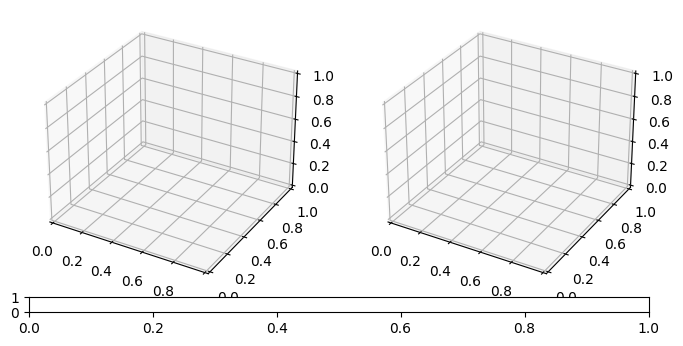

In [72]:
fig = plt.figure(figsize=(8, 4))
gs = plt.GridSpec(100, 2, figure=fig)
 
# create sub plots as grid
ax0 = fig.add_subplot(gs[:95, 0], projection='3d')
ax1 = fig.add_subplot(gs[:95, 1], projection='3d')
ax2 = fig.add_subplot(gs[95:, :])


# Plot
view = 'lateral'

diff_right = nrem_texture_right-wake_texture_right
diff_left = nrem_texture_left-wake_texture_left

max_diff = max(diff_right.max(), diff_left.max())
min_diff = min(diff_right.min(), diff_left.min())

# NREM - Wake
plotting.plot_surf_stat_map(
    fsaverage.infl_right, diff_right, hemi='right',
    title='', colorbar=False, view=view, vmax=max_diff,
    symmetric_cbar=False, threshold=None, cmap='viridis',
    axes=ax0
)

plotting.plot_surf_stat_map(
    fsaverage.infl_left, diff_left, hemi='left',
    title='', colorbar=False, view=view, vmax=max_diff,
    symmetric_cbar=False, threshold=None, cmap='viridis',
    axes=ax1
)

norm = matplotlib.colors.Normalize(vmin=min_diff, vmax=max_diff)

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='viridis'),
             cax=ax2, orientation='horizontal')

ax2.set_xlabel(r'$\tau_{\mathrm{NREM}} - \tau_{\mathrm{Wake}}\ \mathrm{(milliseconds)}$')

ax1.set_title('Non-REM - Wake Timescales')
plt.savefig('nrem_minus_wake.pdf');

### Compare Human vs Rat Timescales

In [67]:
rat_wake_taus_ms = np.load('./rat_taus_lfp_wake.npy')
rat_nrem_taus_ms = np.load('./rat_taus_lfp_nrem.npy')

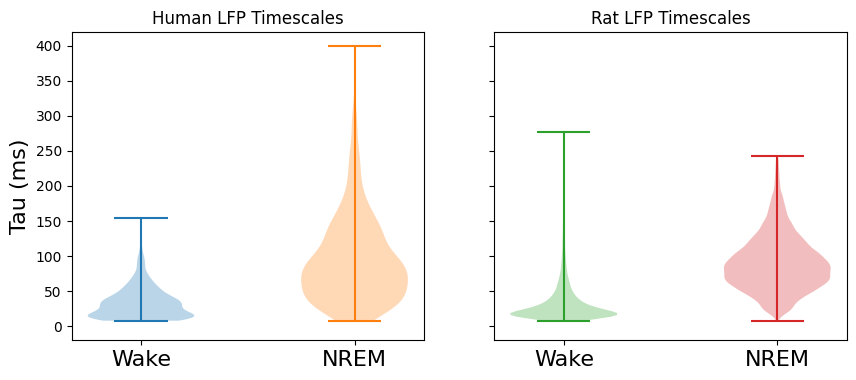

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

axes[0].violinplot(wake_taus_ms, positions=[0])
axes[0].violinplot(nrem_taus_ms, positions=[1])
axes[0].set_xticks([0, 1], ['Wake', 'NREM'], size=16)
axes[0].set_title('Human LFP Timescales')
axes[0].set_ylabel('Tau (ms)', size=16)

axes[1].violinplot([0], positions=[-100])
axes[1].violinplot([0], positions=[-101])

axes[1].violinplot(rat_wake_taus_ms, positions=[0], )
axes[1].violinplot(rat_nrem_taus_ms, positions=[1])
axes[1].set_xticks([0, 1], ['Wake', 'NREM'], size=16)
axes[1].set_title('Rat LFP Timescales')
axes[1].set_xlim(axes[0].get_xlim())
plt.savefig('human_v_rat_v1.pdf');

/var/folders/xq/64b6njb134n_vwp47x74rp240000gn/T/ipykernel_63862/4107444783.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(0, 500, 50)], size=12)


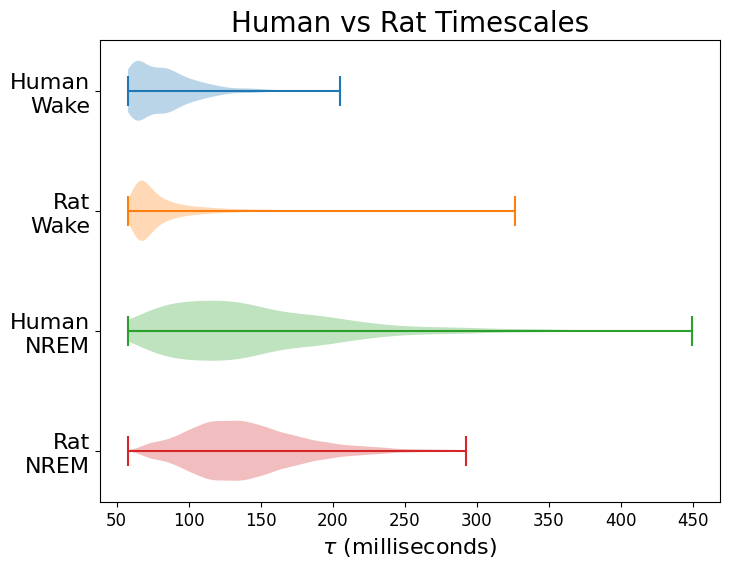

In [71]:
fig, ax = plt.subplots(figsize=(8, 6), sharey=True)

ax.violinplot(wake_taus_ms, positions=[3], vert=False)
ax.violinplot(rat_wake_taus_ms, positions=[2], vert=False)

ax.violinplot(nrem_taus_ms, positions=[1], vert=False)
ax.violinplot(rat_nrem_taus_ms, positions=[0], vert=False)

ax.set_yticks([0, 1, 2, 3][::-1], ['Human\nWake', 'Rat\nWake', 'Human\nNREM',  'Rat\nNREM'], size=16)
ax.set_xticklabels([str(i) for i in np.arange(0, 500, 50)], size=12)
ax.set_title('Human vs Rat Timescales', size=20)
ax.set_xlabel(r'$\tau$ (milliseconds)', size=16)
plt.savefig('human_v_rat_v2.pdf');